In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
import torch.nn as nn
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

Mounted at /content/drive


In [ ]:
class RPN(nn.Module):
    """Region proposal network"""

    def __init__(self, channels, n_anchor):
        super(RPN, self).__init__()
        
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.reg_layer = nn.Conv2d(channels, n_anchor *4, 1, 1, 0)
        self.cls_layer = nn.Conv2d(channels, n_anchor *2, 1, 1, 0) ##use softmax here. equally use sigmoid if replacing 2 with 1.

        # conv sliding layer
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()
        # Regression layer
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()
        # classification layer
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()

    def forward(self, x):
        x = self.conv1(x)
        pred_anchor_locs = self.reg_layer(x)
        pred_cls_scores = self.cls_layer(x)
        #print(pred_cls_scores.shape, pred_anchor_locs.shape)
        #Out:
        #torch.Size([1, 18, 32, 50]) torch.Size([1, 36, 32, 50])
        #print(out_map.shape)
        return pred_anchor_locs, pred_cls_scores

In [ ]:
class Fast_RCNN(nn.Module):
    """fast RCNN"""

    def __init__(self):
        super(Fast_RCNN, self).__init__()
        self.roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096),
                                              nn.Linear(4096, 4096)])
        self.cls_loc = nn.Linear(4096, (n_classes + 1) * 4) # (n_classes + 1 background. Each will have 4 co-ordinates)
        self.cls_loc.weight.data.normal_(0, 0.01)
        self.cls_loc.bias.data.zero_()
        self.score = nn.Linear(4096, n_classes +1) # (n_classes + 1 background)

    def forward(self,x):
        x = self.roi_head_classifier(x)
        roi_cls_loc = self.cls_loc(x)
        roi_cls_score = self.score(x)
        #print(roi_cls_loc.shape, roi_cls_score.shape)
        #Out:
        # torch.Size([128, 84]), torch.Size([128, 21])
        return roi_cls_loc, roi_cls_score 

In [ ]:
def create_fe_extractor():
    """ return layers for backbone network and number of channels in the output_map 
    """
    dummy_img = torch.zeros((1, 3, height, width)).float()
    model = torchvision.models.vgg16(pretrained=True)
    fe = list(model.features)
    req_features = []
    k = dummy_img.clone()
    for i in fe:
         k = i(k)
         #print(k.size())
         if k.size()[3] < width//sub_sample:
             break
         req_features.append(i)
         out_channels = k.size()[1]
    #print(len(req_features)) #30
    #print(out_channels) # 512
    channels = out_channels
    
    return req_features, channels

In [ ]:
def calc_anchors():
    """
    """

    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)
    #print(anchor_base)
    ctr_y = sub_sample / 2.
    ctr_x = sub_sample / 2.

    #print(ctr_y, ctr_x)
    # Out: (8, 8)
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
              h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
              w = sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])

              index = i * len(anchor_scales) + j

              anchor_base[index, 0] = ctr_y - h / 2.
              anchor_base[index, 1] = ctr_x - w / 2.
              anchor_base[index, 2] = ctr_y + h / 2.
              anchor_base[index, 3] = ctr_x + w / 2.

    fe_size_x = (width//sub_sample)
    fe_size_y = (height//sub_sample)
    #print(fe_size_x)
    #print(fe_size_y)

    ctr_x = np.arange(sub_sample, (fe_size_x+1) * sub_sample, sub_sample)
    ctr_y = np.arange(sub_sample, (fe_size_y+1) * sub_sample, sub_sample)

    ctr = np.zeros((len(ctr_x) * len(ctr_y),2))
    index = 0
    for x in range(len(ctr_x)):
        for y in range(len(ctr_y)):
            ctr[index, 1] = ctr_x[x] - 8
            ctr[index, 0] = ctr_y[y] - 8
            index +=1

    anchors = np.zeros(((fe_size_x * fe_size_y * 9), 4))
    index = 0
    for c in ctr:
       ctr_y, ctr_x = c
       for i in range(len(ratios)):
           for j in range(len(anchor_scales)):
               h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
               w = sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])
               anchors[index, 0] = ctr_y - h / 2.
               anchors[index, 1] = ctr_x - w / 2.
               anchors[index, 2] = ctr_y + h / 2.
               anchors[index, 3] = ctr_x + w / 2.
               index += 1
    
    return anchors

In [ ]:
def calc_valid_anchors_and_labels(anchors):
    """ returns all anchors which aren't overlap the image border and label
    """

    index_inside = np.where(#??????????????????????????????????????????????????????????????????????????????????????
            (anchors[:, 0] >= 0) &
            (anchors[:, 1] >= 0) &
            (anchors[:, 2] <= 512) &
            (anchors[:, 3] <= 800)
        )[0]

    #print(index_inside.shape)
    #Out: (4400,)

    label = np.empty((len(index_inside), ), dtype=np.int32)
    label.fill(-1)
    #print(label.shape)
    #Out = (4400, )

    valid_anchor_boxes = anchors[index_inside]
    #print(valid_anchor_boxes.shape)
    #Out = (4400, 4)

    return label, valid_anchor_boxes, index_inside


In [ ]:
def calc_ious(bboxes1, bboxes2):
    """ Calculate ious with vectorization
    """
    
    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    ious = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return ious

In [ ]:
def calc_anchor_locations_and_labels(valid_anchor_boxes, ious, label):
    """ calculate the anchor locatios and anchor labels
    """
    
    #case 1 the highest iou for each gt_box and its corresponding anchor box
    gt_argmax_ious = ious.argmax(axis=0)
    #print(gt_argmax_ious)
    gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
    #print(gt_max_ious)

    #case 2 the highest iou for each anchor box and its corresponding ground truth box
    argmax_ious = ious.argmax(axis=1)
    #print(argmax_ious.shape)
    #print(argmax_ious)
    max_ious = ious[np.arange(len(index_inside)), argmax_ious]
    #print(max_ious)

    gt_argmax_ious = np.where(ious == gt_max_ious)[0]
    #print(gt_argmax_ious)

    label[max_ious < neg_iou_threshold] = 0
    label[gt_argmax_ious] = 1
    label[max_ious >= pos_iou_threshold] = 1

    n_pos = 0.5 * n_sample
    #positive samples
    pos_index = np.where(label == 1)[0]
    if len(pos_index) > n_pos:
        disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
        label[disable_index] = -1

    #negative samples
    n_neg = n_sample * np.sum(label == 1)
    neg_index = np.where(label == 0)[0]
    if len(neg_index) > n_neg:
        disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
        label[disable_index] = -1

    #For each anchor box, find the groundtruth object which has max_iou
    max_iou_bbox = bbox[argmax_ious]

    box_height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0] 
    box_width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
    ctr_y = valid_anchor_boxes[:, 0] + 0.5 * box_height
    ctr_x = valid_anchor_boxes[:, 1] + 0.5 * box_width
    base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
    base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
    base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
    base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

    #find the locs
    eps = np.finfo(box_height.dtype).eps
    box_height = np.maximum(box_height, eps)
    box_width = np.maximum(box_width, eps)
    dy = (base_ctr_y - ctr_y) / box_height
    dx = (base_ctr_x - ctr_x) / box_width
    dh = np.log(base_height / box_height)
    dw = np.log(base_width / box_width)
    anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
    #print(anchor_locs)

    #final labels
    anchor_labels = np.empty((len(anchors),), dtype=label.dtype)
    anchor_labels.fill(-1)
    anchor_labels[index_inside] = label

    #final locations
    anchor_locations = np.empty((len(anchors),) + anchors.shape[1:], dtype=anchor_locs.dtype)
    anchor_locations.fill(0)
    anchor_locations[index_inside, :] = anchor_locs

    return anchor_labels, anchor_locations

In [ ]:
def generate_regions_of_interest(is_training):
    """ generate_region_proposals
    """
    n_pre_nms = n_train_pre_nms if is_training else n_test_pre_nms
    n_post_nms = n_train_post_nms if is_training else n_test_post_nms
    
    anc_height = anchors[:, 2] - anchors[:, 0]
    anc_width = anchors[:, 3] - anchors[:, 1]
    anc_ctr_y = anchors[:, 0] + 0.5 * anc_height
    anc_ctr_x = anchors[:, 1] + 0.5 * anc_width

    pred_anchor_locs_numpy = pred_anchor_locs[0].data.numpy()
    objectness_score_numpy = objectness_score[0].data.numpy()
    dy = pred_anchor_locs_numpy[:, 0::4]
    dx = pred_anchor_locs_numpy[:, 1::4]
    dh = pred_anchor_locs_numpy[:, 2::4]
    dw = pred_anchor_locs_numpy[:, 3::4]
    ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
    ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
    h = np.exp(dh) * anc_height[:, np.newaxis]
    w = np.exp(dw) * anc_width[:, np.newaxis]

    roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=np.float32) #pred_anchor_locs.numpy.dtype) KOMISCH ?!?!?!!?!?!?!?
    roi[:, 0::4] = ctr_y - 0.5 * h
    roi[:, 1::4] = ctr_x - 0.5 * w
    roi[:, 2::4] = ctr_y + 0.5 * h
    roi[:, 3::4] = ctr_x + 0.5 * w

    #img_size = (height, width) #Image size
    #print(img_size)

    roi[:, slice(0, 4, 2)] = np.clip(
                roi[:, slice(0, 4, 2)], 0, img_size[0])
    roi[:, slice(1, 4, 2)] = np.clip(
        roi[:, slice(1, 4, 2)], 0, img_size[1])

    #print(roi)

    hs = roi[:, 2] - roi[:, 0]
    ws = roi[:, 3] - roi[:, 1]
    keep = np.where((hs >= min_size) & (ws >= min_size))[0]
    roi = roi[keep, :]
    score = objectness_score_numpy[keep]
    #print(score.shape)

    ordered_scores = score.ravel().argsort()[::-1]
    #print(ordered_scores)

    ordered_scores = ordered_scores[:n_pre_nms]
    roi = roi[ordered_scores, :]

    #print(roi.shape)
    #print(roi)

    y1 = roi[:, 0]
    x1 = roi[:, 1]
    y2 = roi[:, 2]
    x2 = roi[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = ordered_scores.argsort()[::-1]
    keep = []
    while (order.size > 0):
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= nms_thresh)[0]
        order = order[inds + 1]
    keep = keep[:n_post_nms] # while training/testing , use accordingly
    roi = roi[keep] # the final region proposals

    return roi

In [ ]:
def create_region_proposals():
    """ Create sample rois, ground truth roi labels and ground truth roi locations
    """

    gt_assignment = ious.argmax(axis=1)
    max_iou = ious.max(axis=1)
    #print(gt_assignment)
    #print(max_iou)

    gt_roi_label = labels[gt_assignment]
    #print(gt_roi_label) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    pos_roi_per_image = int(n_sample * pos_ratio)
    pos_index = np.where(max_iou >= pos_iou_thresh)[0]
    pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
    if pos_index.size > 0:
        pos_index = np.random.choice(
            pos_index, size=pos_roi_per_this_image, replace=False)
    #print(pos_roi_per_this_image)
    #print(pos_index)

    neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
    neg_roi_per_this_image = n_sample - pos_roi_per_this_image
    neg_roi_per_this_image = int(min(neg_roi_per_this_image,
                                 neg_index.size))
    if  neg_index.size > 0 :
        neg_index = np.random.choice(
            neg_index, size=neg_roi_per_this_image, replace=False)
    #print(neg_roi_per_this_image)
    #print(neg_index)
    keep_index = np.append(pos_index, neg_index)
    gt_roi_labels = gt_roi_label[keep_index]
    gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
    sample_roi = roi[keep_index]
    #print(sample_roi.shape)

    bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
    #print(bbox_for_sampled_roi.shape)
    #Out
    #(128, 4)
    h = sample_roi[:, 2] - sample_roi[:, 0]
    w = sample_roi[:, 3] - sample_roi[:, 1]
    ctr_y = sample_roi[:, 0] + 0.5 * h
    ctr_x = sample_roi[:, 1] + 0.5 * w
    base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
    base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
    base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
    base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

    eps = np.finfo(h.dtype).eps
    h = np.maximum(h, eps)
    w = np.maximum(w, eps)
    dy = (base_ctr_y - ctr_y) / h
    dx = (base_ctr_x - ctr_x) / w
    dh = np.log(base_height / h)
    dw = np.log(base_width / w)
    gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
    #print(gt_roi_locs) ############################## now gt_roi_locs and gt_roi_labels

    return sample_roi, gt_roi_labels, gt_roi_locs

In [ ]:
def roi_pooling(sample_roi):
    """ calculates roi pooling for sample_rois
    """

    rois = torch.from_numpy(sample_roi).float()
    roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
    roi_indices = torch.from_numpy(roi_indices).float()
    #print(rois.shape, roi_indices.shape)
    #Out:
    #torch.Size([128, 4]) torch.Size([128])

    indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
    xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]  
    indices_and_rois = xy_indices_and_rois.contiguous()
    #print(xy_indices_and_rois.shape)
    size = (7, 7)
    adaptive_max_pool = nn.AdaptiveMaxPool2d(size)
    output = []
    rois = indices_and_rois.data.float()
    rois[:, 1:].mul_(1/16.0) # Subsampling ratio
    rois = rois.long()
    num_rois = rois.size(0)
    for i in range(num_rois):
        roi = rois[i]
        im_idx = roi[0]
        im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
        output.append(adaptive_max_pool(im))
    output = torch.cat(output, 0)
    #print(output.size())
    #Out:
    # torch.Size([128, 512, 7, 7])
    # Reshape the tensor so that we can pass it through the feed forward layer.
    k = output.view(output.size(0), -1)
    #print(k.shape)
    #Out:
    # torch.Size([128, 25088])
    return k

In [ ]:
def calc_rpn_loss():
    """ calculate the rpns loss 
    """

    #rpn classification loss
    rpn_loc = pred_anchor_locs[0]
    rpn_score = pred_cls_scores[0]
    gt_rpn_loc = torch.from_numpy(anchor_locations)
    gt_rpn_score = torch.from_numpy(anchor_labels)
    #print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)  
    rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long(), ignore_index = -1)
    #print(rpn_cls_loss)

    #rpn regression loss
    pos = gt_rpn_score > 0
    mask = pos.unsqueeze(1).expand_as(rpn_loc)
    #print(mask.shape)
    mask_loc_preds = rpn_loc[mask].view(-1, 4)
    mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
    #print(mask_loc_preds.shape, mask_loc_preds.shape)
    x = torch.abs(mask_loc_targets - mask_loc_preds)
    rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
    #print(rpn_loc_loss.sum())
    N_reg = (gt_rpn_score >0).float().sum()
    rpn_loc_loss = rpn_loc_loss.sum() / N_reg

    rpn_loss = rpn_cls_loss + rpn_lambda*rpn_loc_loss

    return rpn_loss

In [ ]:
def calc_fast_rcnn_loss():
    """ calculate the fast-RCNN classification and regression loss 
    """

    #Fast R-CNN classification loss
    gt_roi_loc = torch.from_numpy(gt_roi_locs)
    gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
    #print(gt_roi_loc.shape, gt_roi_label.shape)

    roi_cls_loss = F.cross_entropy(roi_cls_score, gt_roi_label, ignore_index=-1)
    #print(roi_cls_loss)

    #Fast R-CNN Regression loss
    n_sample = roi_cls_loc.shape[0]
    roi_loc = roi_cls_loc.view(n_sample, -1, 4)
    #print(roi_loc.shape)
    #Out:
    #torch.Size([128, 21, 4])
    roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
    #print(roi_loc.shape)
    #Out:
    #torch.Size([128, 4])
    n_sample = roi_cls_loc.shape[0]
    roi_loc = roi_cls_loc.view(n_sample, -1, 4)
    #print(roi_loc.shape)
    roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
    #print(roi_loc.shape)
    x_roi = torch.abs(gt_roi_loc - roi_loc)
    roi_loc_loss = (((x_roi < 1).float() * 0.5 * x_roi ** 2) + ((x_roi >= 1).float() * (x_roi - 0.5)))
    #print(roi_loc_loss.sum())

    gt_rpn_score = torch.from_numpy(anchor_labels)
    N_reg_roi = (gt_rpn_score > 0).float().sum()
    roi_loc_loss = roi_loc_loss.sum() / N_reg_roi
    roi_loss = roi_cls_loss + roi_lambda * roi_loc_loss
    #print(roi_loss)

    return roi_loss

In [ ]:
input = Image.open("/content/drive/MyDrive/Computer Vision/0000f77c-6257be58.jpg") #800x512

In [ ]:
input.size

(1280, 720)

In [ ]:
height = 512 ##########################################################################################################################
width = 800 ##########################################################################################################################
img_size = (height, width)
n_classes = 13

In [ ]:
transform = transforms.Compose([transforms.Resize((height, width)),
                                     transforms.ToTensor()])

In [ ]:
input_tensor = transform(input)

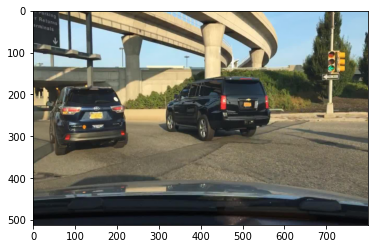

In [ ]:
plt.imshow(input_tensor.permute(1,2,0))

In [ ]:
image = torch.zeros((1, 3, height, width)).float() #800)).float()

bbox = torch.FloatTensor([[20, 30, 300, 400], [100, 200, 400, 400]]) # [y1, x1, y2, x2] format
labels = torch.LongTensor([6, 8]) # 0 represents background
sub_sample = 16##########################################################################################

In [ ]:
#Create Network Backbone
req_features, channels = create_fe_extractor()
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
print(faster_rcnn_fe_extractor)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
out_map = faster_rcnn_fe_extractor(image)
print(out_map.size())
#Out: torch.Size([1, 512, 32, 50])

torch.Size([1, 512, 32, 50])


In [ ]:
#create anchors
ratios = [0.5, 1, 2]###########################################################################################################
anchor_scales = [8, 16, 32]#####################################################################################################
n_anchor = len(ratios) * len(anchor_scales)
print(n_anchor)

anchors = calc_anchors()
print(anchors.shape)
    #Out: [14400, 4]

9
(14400, 4)


In [ ]:
print(anchors)

[[ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 ...
 [ 413.49033201  746.745166    594.50966799  837.254834  ]
 [ 322.98066402  701.49033201  685.01933598  882.50966799]
 [ 141.96132803  610.98066402  866.03867197  973.01933598]]


In [ ]:
label, valid_anchor_boxes, index_inside = calc_valid_anchors_and_labels(anchors)

In [ ]:
ious = calc_ious(valid_anchor_boxes, bbox.numpy())

In [ ]:
print(ious[:100])
#Out: [22500, 2]

[[0.11717526 0.        ]
 [0.12205174 0.        ]
 [0.12205174 0.        ]
 [0.12205174 0.        ]
 [0.12205174 0.        ]
 [0.12205174 0.        ]
 [0.12205174 0.        ]
 [0.11717526 0.        ]
 [0.10536766 0.        ]
 [0.09380704 0.        ]
 [0.08248574 0.        ]
 [0.07139639 0.        ]
 [0.06053195 0.        ]
 [0.04988563 0.        ]
 [0.03945094 0.        ]
 [0.02922163 0.        ]
 [0.01919169 0.        ]
 [0.00935535 0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.1155177  0.        ]
 [0.12889279 0.        ]
 [0.12889279 0.        ]
 [0.1469349  0.        ]
 [0.12889279 0.        ]
 [0.15321975 0.        ]
 [0.12889279 0.        ]
 [0.15321975 0.        ]
 [0.12889279 0.        ]
 [0.15321975 0.        ]
 [0.12889279 0.        ]
 [0.15321975 0.        ]
 [0.12889279 0.        ]
 [0.15321975 0.        ]
 [0.12889279 0.        ]
 [0.15321975 0.        ]
 [0.12889279 0.        ]
 [0.1469349  0.        ]
 [0.12889279 0.        ]
 [0.13177474 0.        ]


In [ ]:
ious.max()

0.7631334336124749

In [ ]:
pos_iou_threshold  = 0.7 #########################################################################
neg_iou_threshold = 0.3 ##########################################################################

n_sample = 256 ###########################################################################################################

In [ ]:
anchor_labels, anchor_locations = calc_anchor_locations_and_labels(valid_anchor_boxes, ious, label)

In [ ]:
anchor_labels.size

14400

In [ ]:
for loc in anchor_locations:
  print(loc)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
[-0.3046875  -0.859375    0.15860503 -0.24686008]
[0. 0. 0. 0.]
[-0.92807765 -3.36980575  0.43618575  1.40804633]
[-0.46403883 -1.68490288 -0.25696143  0.71489915]
[0. 0. 0. 0.]
[-2.032932   -1.68490288  1.12933293  0.71489915]
[-0.51928154 -0.60766989  0.50517862 -0.59343367]
[0. 0. 0. 0.]
[-1.4375     -2.3828125   0.78275934  1.06147274]
[-0.3671875  -0.859375    0.15860503 -0.24686008]
[0. 0. 0. 0.]
[-1.016466   -3.36980575  0.43618575  1.40804633]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[-2.20970869 -1.68490288  1.12933293  0.71489915]
[-0.60766989 -0.60766989  0.50517862 -0.59343367]
[0. 0. 0. 0.]
[-1.5625     -2.3828125   0.78275934  1.06147274]
[-0.4296875  -0.859375    0.15860503 -0.24686008]
[0. 0. 0. 0.]
[-1.10485435 -3.36980575  0.43618575  1.40804633]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[-2.38648539 -1.68490288  1.12933293  0.71489915]
[-0.69605824 -0.60766989  0.50517862 -0.59343367]
[0. 0. 0. 0.]
[-1.6875     -2.3828125   0.7

In [ ]:
rpn = RPN(channels, n_anchor) ############außerhalb der schleife packen !!!!

In [ ]:
pred_anchor_locs, pred_cls_scores = rpn(out_map)

In [ ]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)
#Out: torch.Size([1, 22500, 4])
pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)
#Out torch.Size([1, 50, 50, 18])
objectness_score = pred_cls_scores.view(out_map.shape[0], out_map.shape[2], out_map.shape[3], 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)
#Out torch.Size([1, 22500])
pred_cls_scores  = pred_cls_scores.view(out_map.shape[0], -1, 2)
print(pred_cls_scores.shape)
# Out torch.size([1, 22500, 2])

torch.Size([1, 14400, 4])
torch.Size([1, 32, 50, 18])
torch.Size([1, 14400])
torch.Size([1, 14400, 2])


In [ ]:
#is_training = True #!!!!!!!!?????????!!!!!!!!!???????????!!!!!!!!!!!??????????!!!!!!!!!?????????????????????????

nms_thresh = 0.7 ###############################################################################################
n_train_pre_nms = 12000 ########################################################################################
n_train_post_nms = 2000 ########################################################################################
n_test_pre_nms = 6000 ##########################################################################################
n_test_post_nms = 300 ##########################################################################################
min_size = 16 ##################################################################################################

In [ ]:
roi = generate_regions_of_interest(True)

In [ ]:
#Proposal targets
n_sample = 128 #Number of samples to sample from roi, The default value is 128.
pos_ratio = 0.25 #the number of positive examples out of the n_samples. The default values is 0.25.
pos_iou_thresh = 0.5 #the number of positive examples out of the n_samples. The default values is 0.25.
neg_iou_thresh_hi = 0.5 #The minimum overlap of region proposal with any groundtruth object to consider it as positive label.
neg_iou_thresh_lo = 0.0 #The overlap value bounding required to consider a region proposal as negitive [background object].

In [ ]:
ious = calc_ious(roi,  bbox.numpy())

In [ ]:
print(ious.shape)

(1700, 2)


In [ ]:
sample_roi, gt_roi_labels, gt_roi_locs = create_region_proposals()

In [ ]:
sample_roi.shape

(128, 4)

In [ ]:
fast_rcnn = Fast_RCNN()

roi_pool_out = roi_pooling(sample_roi)
roi_cls_loc, roi_cls_score = fast_rcnn(roi_pool_out)

In [ ]:
#calc loss
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 14400, 4])
torch.Size([1, 14400, 2])
(14400, 4)
(14400,)


In [ ]:
rpn_lambda = 10#############################################################################
rpn_loss = calc_rpn_loss()

In [ ]:
print(roi_cls_loc.shape)
print(roi_cls_score.shape)
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 56])
torch.Size([128, 14])
(128, 4)
torch.Size([128])


In [ ]:
roi_lambda = 10#############################################################
roi_loss = calc_fast_rcnn_loss()

In [ ]:
#total_loss
total_loss = rpn_loss + roi_loss
print(total_loss)

tensor(128.1377, dtype=torch.float64, grad_fn=<AddBackward0>)


In [ ]:
############################################################################################################################################################################

In [ ]:
#set configs
height = 512 ##########################################################################################################################
width = 800 ##########################################################################################################################
sub_sample = 16##########################################################################################
ratios = [0.5, 1, 2]###########################################################################################################
anchor_scales = [8, 16, 32]#####################################################################################################
pos_iou_threshold  = 0.7 #########################################################################
neg_iou_threshold = 0.3 ##########################################################################
n_sample = 256 ###########################################################################################################
#is_training = True #!!!!!!!!?????????!!!!!!!!!???????????!!!!!!!!!!!??????????!!!!!!!!!?????????????????????????

nms_thresh = 0.7 ###############################################################################################
n_train_pre_nms = 12000 ########################################################################################
n_train_post_nms = 2000 ########################################################################################
n_test_pre_nms = 6000 ##########################################################################################
n_test_post_nms = 300 ##########################################################################################
min_size = 16 ##################################################################################################

#Proposal targets
n_sample = 128 #Number of samples to sample from roi, The default value is 128.
pos_ratio = 0.25 #the number of positive examples out of the n_samples. The default values is 0.25.
pos_iou_thresh = 0.5 #the number of positive examples out of the n_samples. The default values is 0.25.
neg_iou_thresh_hi = 0.5 #The minimum overlap of region proposal with any groundtruth object to consider it as positive label.
neg_iou_thresh_lo = 0.0 #The overlap value bounding required to consider a region proposal as negitive [background object].

rpn_lambda = 10#############################################################################
roi_lambda = 10#############################################################

In [ ]:
#prepare data
input = Image.open("/content/drive/MyDrive/Computer Vision/0000f77c-6257be58.jpg") #800x512
img_size = (height, width)
n_classes = 13
transform = transforms.Compose([transforms.Resize((height, width)),
                                     transforms.ToTensor()])
input_tensor = transform(input)
image = torch.zeros((1, 3, height, width)).float() #800)).float()

bbox = torch.FloatTensor([[20, 30, 300, 400], [100, 200, 400, 400]]) # [y1, x1, y2, x2] format
labels = torch.LongTensor([6, 8]) # 0 represents background

In [ ]:
#create anchors
n_anchor = len(ratios) * len(anchor_scales)
print(n_anchor)

anchors = calc_anchors()
print(anchors.shape)
    #Out: [14400, 4]

9
(14400, 4)


In [ ]:
#set network optimizer etc.
# set a boolean flag that indicates whether a cuda capable GPU is available
# we will need this for transferring our tensors to the device and
# for persistent memory in the data loader
is_gpu = torch.cuda.is_available()
print("GPU is available:", is_gpu)
print("If you are receiving False, try setting your runtime to GPU")

# set the device to cuda if a GPU is available
device = torch.device("cuda" if is_gpu else "cpu")

#create Network Backbone
req_features, channels = create_fe_extractor()
faster_rcnn_fe_extractor = nn.Sequential(*req_features).to(device)
print(faster_rcnn_fe_extractor)

#create RPN
rpn = RPN(channels, n_anchor).to(device) 

#create Fast-RCNN
fast_rcnn = Fast_RCNN().to(device)
params = list(faster_rcnn_fe_extractor.parameters()) + list(rpn.parameters()) + list(fast_rcnn.parameters())
#model.load_state_dict(torch.load("/content/drive/My Drive/weights15.pt"))#####################################################################

#set optimizer for backpropagation
optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=5e-4)

GPU is available: False
If you are receiving False, try setting your runtime to GPU


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_s

In [ ]:
for i in range(1000):
    print("step",i)
    #train loop (faster_rcnn_fe_extractor, anchors, )
    label, valid_anchor_boxes, index_inside = calc_valid_anchors_and_labels(anchors)

    ious = calc_ious(valid_anchor_boxes, bbox.numpy())
    n_sample = 256 ###########################################################################################################
    anchor_labels, anchor_locations = calc_anchor_locations_and_labels(valid_anchor_boxes, ious, label)

    image.to(device)###########?!?!??!?!?!????????????????????!!!!!!!!!!!!!!?????????!!!!!!!!???????!!!!!!!!??????!
    out_map = faster_rcnn_fe_extractor(image).to(device)

    pred_anchor_locs, pred_cls_scores = rpn(out_map)

    pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
    #print(pred_anchor_locs.shape)
    #Out: torch.Size([1, 22500, 4])
    pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
    #print(pred_cls_scores.shape)
    #Out torch.Size([1, 50, 50, 18])
    objectness_score = pred_cls_scores.view(out_map.shape[0], out_map.shape[2], out_map.shape[3], 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
    #print(objectness_score.shape)
    #Out torch.Size([1, 22500])
    pred_cls_scores  = pred_cls_scores.view(out_map.shape[0], -1, 2)
    #print(pred_cls_scores.shape)
    # Out torch.size([1, 22500, 2])

    roi = generate_regions_of_interest(True) ############################!!!!!!!!!!!!!!!!!???????????????????!!!!!!!!!!!!!!!??????????????!!!!!!!!!!!!???????????!!!!!!

    n_sample = 128 #Number of samples to sample from roi, The default value is 128.
    ious = calc_ious(roi,  bbox.numpy())
    sample_roi, gt_roi_labels, gt_roi_locs = create_region_proposals()

    roi_pool_out = roi_pooling(sample_roi)
    roi_cls_loc, roi_cls_score = fast_rcnn(roi_pool_out)

    rpn_loss = calc_rpn_loss()
    print(rpn_loss)

    roi_loss = calc_fast_rcnn_loss()
    print(roi_loss)
    #total_loss
    total_loss = rpn_loss + roi_loss
    print(total_loss)

    # compute gradient and do the SGD step
    # we reset the optimizer with zero_grad to "flush" former gradients
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

step 0
tensor(1.2669, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(181.8224, grad_fn=<AddBackward0>)
tensor(183.0893, dtype=torch.float64, grad_fn=<AddBackward0>)
step 1
tensor(1.2668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(180.6567, grad_fn=<AddBackward0>)
tensor(181.9235, dtype=torch.float64, grad_fn=<AddBackward0>)
step 2
tensor(1.2658, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(170.8002, grad_fn=<AddBackward0>)
tensor(172.0659, dtype=torch.float64, grad_fn=<AddBackward0>)
step 3
tensor(1.2654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(172.4782, grad_fn=<AddBackward0>)
tensor(173.7436, dtype=torch.float64, grad_fn=<AddBackward0>)
step 4
tensor(1.2654, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(163.9523, grad_fn=<AddBackward0>)
tensor(165.2177, dtype=torch.float64, grad_fn=<AddBackward0>)
step 5
tensor(1.2655, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(156.3661, grad_fn=<AddBackward0>)
tensor(157.6316, dtype=torch.float64, grad